In [1]:
# !pip install wordcloud scikit-network datasets
# !pip install tiktoken openai transformers sentence_transformers

# !pip install -U 'spacy[apple]'
# # !pip install -U 'spacy[cuda12x]'

In [1]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
import spacy; spacy.prefer_gpu()
import tiktoken
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from vertexai.preview import tokenization
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForTokenClassification
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize

import networkx as nx
from transformers.pipelines import pipeline

from src.helpers import preprocessing as preproc
from src.helpers import postprocessing as postproc
from src.helpers.postprocessing import from_list_to_string
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wro

In [2]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.getenv("OUTPUTS_PATH")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [3]:
df = pd.read_pickle(os.path.join(DATA_PATH, "us_fed_speeches.pickle"))
FILES_PREFIX = "us_speeches"

In [4]:
df

,date,text,label
0,2004-01-03,Ben S Bernanke: Fedspeak\nSpeech by Mr Ben S B...,1.0
1,2004-01-03,Ben S Bernanke: Conducting monetary policy at ...,1.0
2,2004-01-03,Alan Greenspan: Risk and uncertainty in moneta...,1.0
3,2004-01-04,Ben S Bernanke: Monetary policy and the econom...,1.0
4,2004-01-04,"Roger W Ferguson, Jr: Lessons from past produc...",1.0
...,...,...,...
595,2010-03-25,Ben S Bernanke: Federal Reserve's exit strateg...,1.0
596,2010-03-26,Daniel K Tarullo: Lessons from the crisis stre...,1.0
597,2010-03-26,Kevin Warsh: An ode to independence\nSpeech by...,1.0
598,2010-03-26,Brian P Sack: Dollar asset markets - prospects...,1.0


# Pre-processing data

##### 1. Data cleaning

In [5]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Generating cleaned texts for 600 raw texts...


  0%|          | 0/600 [00:00<?, ?it/s]

Saved 600 cleaned texts to /Users/tig1/Programming/TOPOL/data/us_speeches_texts.pickle.


##### 2. Embedding texts

In [7]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Generating embeddings for 600 text...


Encoding batches (get_embeddings):   0%|          | 0/600 [00:00<?, ?it/s]

Encoding batches (get_embeddings): 100%|██████████| 600/600 [04:32<00:00,  2.20it/s]

Saved 600 embeddings to /Users/tig1/Programming/TOPOL/data/us_speeches_embeddings.pickle.


##### 3. Sentiment Analysis

In [ ]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, max_length=512)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment"] = sentiments
df["sentiment_score"] = df["sentiment"].apply(sentiment_model.get_sentiment_score)
del fpath

tf_model.h5:   0%|          | 0.00/438M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps


Generating sentiments for 600 texts...


  0%|          | 0/600 [00:00<?, ?it/s]

KeyError: 'document'

# TOPOL Modeling

### Prepare data

In [ ]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

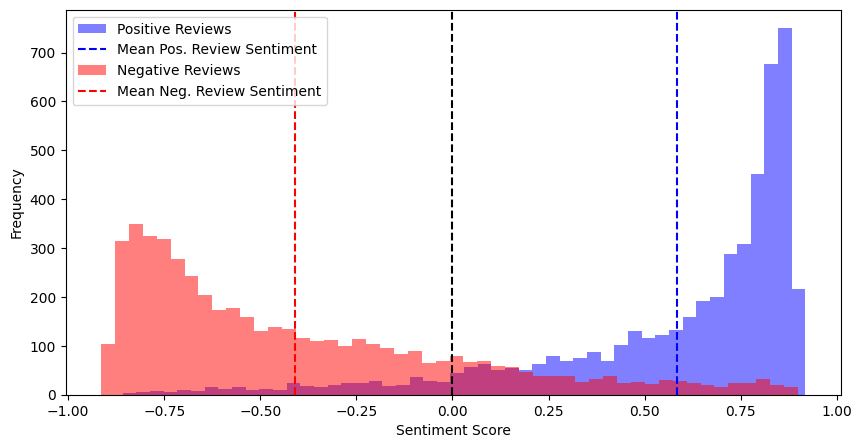

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score"].values, bins=50, alpha=0.5, label='Positive Reviews', color='blue')
plt.axvline(x=data_A["sentiment_score"].mean(), color='blue', linestyle='--', label='Mean Pos. Review Sentiment')
plt.hist(data_B["sentiment_score"].values, bins=50, alpha=0.5, label='Negative Reviews', color='red')
plt.axvline(x=data_B["sentiment_score"].mean(), color='red', linestyle='--', label='Mean Neg. Review Sentiment')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig(os.path.join(OUTPUTS_PATH, "sentiment_score_frequency_amazon_reviews.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [ ]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine',
    'transform_mode': "embedding",
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=False,
)

### TOPOL modeling analysis

In [ ]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
topol_model.dataset_A.cluster_info

In [ ]:
topol_model.dataset_B.cluster_info

AttributeError: 'NoneType' object has no attribute 'iterrows'

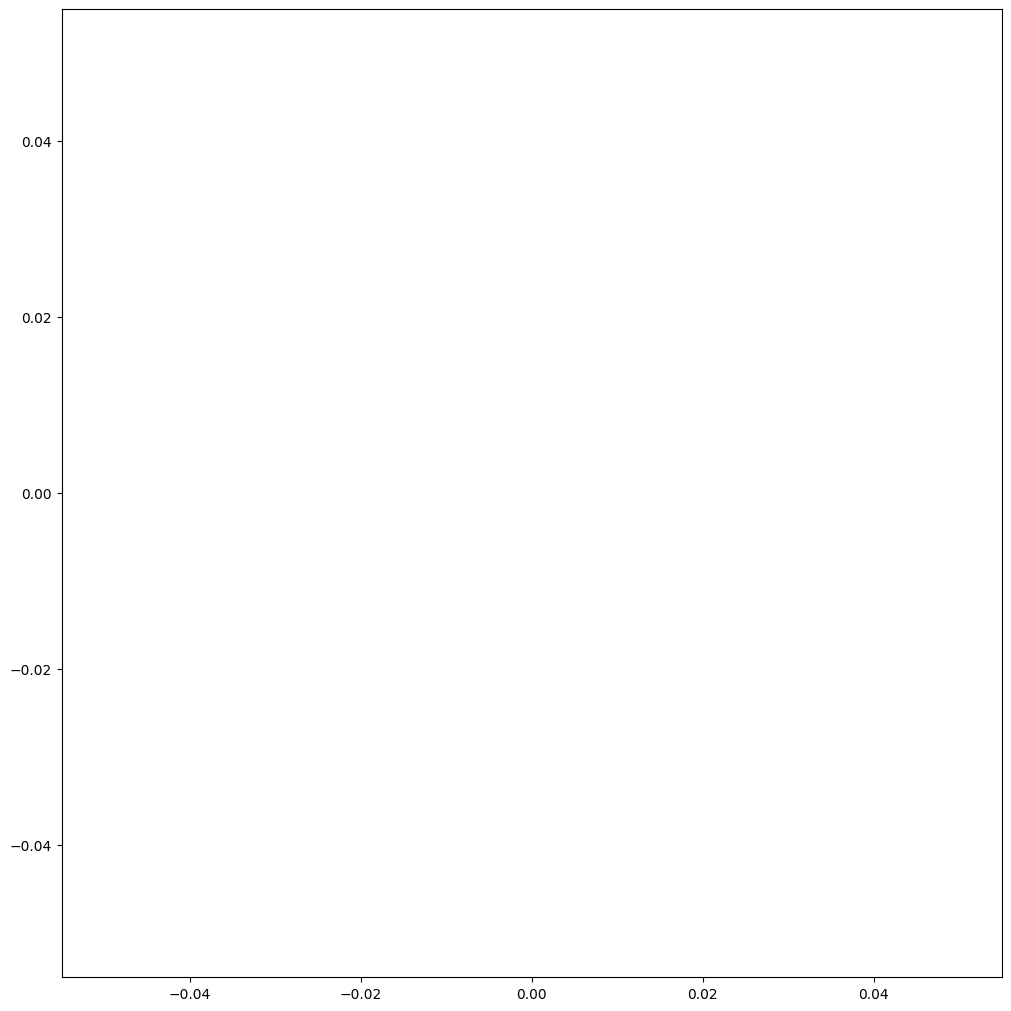

In [ ]:
fig, ax = topol_model.vizualize_clusters()
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [ ]:
drifts_df = pd.DataFrame.from_dict(topol_model.drifts, orient='index', columns=['x', 'y']).dropna()
drifts_df.index.name = "Cluster"

In [ ]:
# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# # KMeans on unit vectors ≈ angular k-means (cosine similarity)
# kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
# drifts_df["labels"] = kmeans.fit_predict(unit_drifts)

# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Drift explainability

In [ ]:
fpath = os.path.join(DATA_PATH, "narrative_dimensions.pickle")
if os.path.exists(fpath):
    with open(fpath, "rb") as f:
        NARRATIVE_DIMENSIONS = pickle.load(f)
    print(f"Loaded {len(NARRATIVE_DIMENSIONS)} narrative dimensions from {fpath}")
else:
    raise FileNotFoundError(f"File {fpath} not found. Please generate narrative dimensions first.")
del fpath

In [ ]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

In [ ]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####DIMENSIONS_LIST#####", from_list_to_string(NARRATIVE_DIMENSIONS))
    prompt = prompt.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [ ]:
# chat_completion_func = openai_chat_completion
chat_completion_func = google_chat_completion

In [ ]:
# zipped_representative_docs = list(zip(
#     topol_model.dataset_A.cluster_info['Top_Representative_Docs'],
#     topol_model.dataset_B.cluster_info['Top_Representative_Docs']
# ))
# top_n_docs = 3  # Number of top documents to compare per cluster

# for i, (top_docs_A, top_docs_B) in tqdm(enumerate(zipped_representative_docs), total=len(zipped_representative_docs)):

#     # Get the representative documents for each cluster
#     if top_n_docs is not None:
#         text1 = from_list_to_string(top_docs_A[:top_n_docs])  # Take top N docs for cluster A
#         text2 = from_list_to_string(top_docs_B[:top_n_docs])  # Take top N docs for cluster B
#     else:
#         text1 = from_list_to_string(top_docs_A)
#         text2 = from_list_to_string(top_docs_B)

#     # Generate the prompt for the LLM
#     prompt = generate_narrative_comparison_prompt(text1, text2)
#     response = chat_completion_func(prompt)

#     # Dynamic response variable (you can also use a list or dict instead of naming each one)
#     var_name = f"response_row{i}"
#     globals()[var_name] = response

#     # Parse the JSON response safely
#     parsed_llm_out = safe_json_load(response)

#     # Save to file
#     with open(f"{OUTPUTS_PATH}/{FILES_PREFIX}_ND_row{i}.json", "w", encoding="utf-8") as f:
#         json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

#     print(f"✅ Processed and saved row {i}")